In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib

print("Library siap!")

Library siap!


In [2]:
# Model 3 butuh data per USER per REPO
# Kita tidak punya data ini dari Kaggle, jadi kita generate synthetic
# yang realistis berdasarkan distribusi yang masuk akal

np.random.seed(42)
n_samples = 1500  # 1500 simulasi member

def generate_member_data(n):
    data = []
    for _ in range(n):
        # Pilih tipe member secara acak dengan proporsi realistis
        member_type = np.random.choice(
            ["active", "passive", "inactive"],
            p=[0.4, 0.35, 0.25]
        )

        if member_type == "active":
            data.append({
                "commit_velocity":      np.random.uniform(2.0, 15.0),
                "contribution_share":   np.random.uniform(0.3, 0.8),
                "activity_consistency": np.random.uniform(0.1, 1.5),
                "active_weeks_ratio":   np.random.uniform(0.6, 1.0),
            })
        elif member_type == "passive":
            data.append({
                "commit_velocity":      np.random.uniform(0.2, 2.0),
                "contribution_share":   np.random.uniform(0.05, 0.3),
                "activity_consistency": np.random.uniform(1.5, 4.0),
                "active_weeks_ratio":   np.random.uniform(0.2, 0.6),
            })
        else:  # inactive
            data.append({
                "commit_velocity":      np.random.uniform(0.0, 0.2),
                "contribution_share":   np.random.uniform(0.0, 0.05),
                "activity_consistency": np.random.uniform(3.0, 8.0),
                "active_weeks_ratio":   np.random.uniform(0.0, 0.2),
            })

    return pd.DataFrame(data)

df_member = generate_member_data(n_samples)
print(f"Shape: {df_member.shape}")
print(df_member.describe())

Shape: (1500, 4)
       commit_velocity  contribution_share  activity_consistency  \
count      1500.000000         1500.000000           1500.000000   
mean          4.029630            0.297829              2.602767   
std           4.648763            0.251781              2.053455   
min           0.000120            0.000078              0.100562   
25%           0.223580            0.052427              0.938492   
50%           1.587138            0.234349              2.078441   
75%           7.450367            0.519607              3.677111   
max          14.969739            0.799446              7.996752   

       active_weeks_ratio  
count         1500.000000  
mean             0.493869  
std              0.305410  
min              0.000271  
25%              0.204404  
50%              0.485763  
75%              0.772823  
max              0.999823  


In [3]:
FEATURES = ["commit_velocity", "contribution_share",
            "activity_consistency", "active_weeks_ratio"]

X = df_member[FEATURES].copy()

# Scale dulu sebelum KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means dengan k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_member["cluster"] = kmeans.fit_predict(X_scaled)

# Lihat rata-rata tiap cluster
cluster_summary = df_member.groupby("cluster")[FEATURES].mean()
print("Rata-rata per cluster:")
print(cluster_summary.round(3))

Rata-rata per cluster:
         commit_velocity  contribution_share  activity_consistency  \
cluster                                                              
0                  0.097               0.024                 5.912   
1                  8.589               0.557                 0.814   
2                  0.985               0.153                 2.797   

         active_weeks_ratio  
cluster                      
0                     0.100  
1                     0.804  
2                     0.358  


In [4]:
# Cluster dengan commit_velocity tertinggi = Active
# Cluster dengan commit_velocity terendah = Inactive
# Sisanya = Passive

cv_means = df_member.groupby("cluster")["commit_velocity"].mean()
print("commit_velocity per cluster:")
print(cv_means)

cluster_map = {
    cv_means.idxmax(): "Active",
    cv_means.idxmin(): "Inactive",
}
remaining = [c for c in [0, 1, 2] if c not in cluster_map]
cluster_map[remaining[0]] = "Passive"

print(f"\nCluster mapping: {cluster_map}")

df_member["member_status"] = df_member["cluster"].map(cluster_map)

print("\nDistribusi label:")
print(df_member["member_status"].value_counts())
print("\nDistribusi (%):")
print((df_member["member_status"].value_counts(normalize=True) * 100).round(1))

commit_velocity per cluster:
cluster
0    0.096963
1    8.589226
2    0.985218
Name: commit_velocity, dtype: float64

Cluster mapping: {np.int32(1): 'Active', np.int32(0): 'Inactive', 2: 'Passive'}

Distribusi label:
member_status
Active      637
Passive     551
Inactive    312
Name: count, dtype: int64

Distribusi (%):
member_status
Active      42.5
Passive     36.7
Inactive    20.8
Name: proportion, dtype: float64


In [5]:
# Cluster dengan commit_velocity tertinggi = Active
# Cluster dengan commit_velocity terendah = Inactive
# Sisanya = Passive

cv_means = df_member.groupby("cluster")["commit_velocity"].mean()
print("commit_velocity per cluster:")
print(cv_means)

cluster_map = {
    cv_means.idxmax(): "Active",
    cv_means.idxmin(): "Inactive",
}
remaining = [c for c in [0, 1, 2] if c not in cluster_map]
cluster_map[remaining[0]] = "Passive"

print(f"\nCluster mapping: {cluster_map}")

df_member["member_status"] = df_member["cluster"].map(cluster_map)

print("\nDistribusi label:")
print(df_member["member_status"].value_counts())
print("\nDistribusi (%):")
print((df_member["member_status"].value_counts(normalize=True) * 100).round(1))

commit_velocity per cluster:
cluster
0    0.096963
1    8.589226
2    0.985218
Name: commit_velocity, dtype: float64

Cluster mapping: {np.int32(1): 'Active', np.int32(0): 'Inactive', 2: 'Passive'}

Distribusi label:
member_status
Active      637
Passive     551
Inactive    312
Name: count, dtype: int64

Distribusi (%):
member_status
Active      42.5
Passive     36.7
Inactive    20.8
Name: proportion, dtype: float64


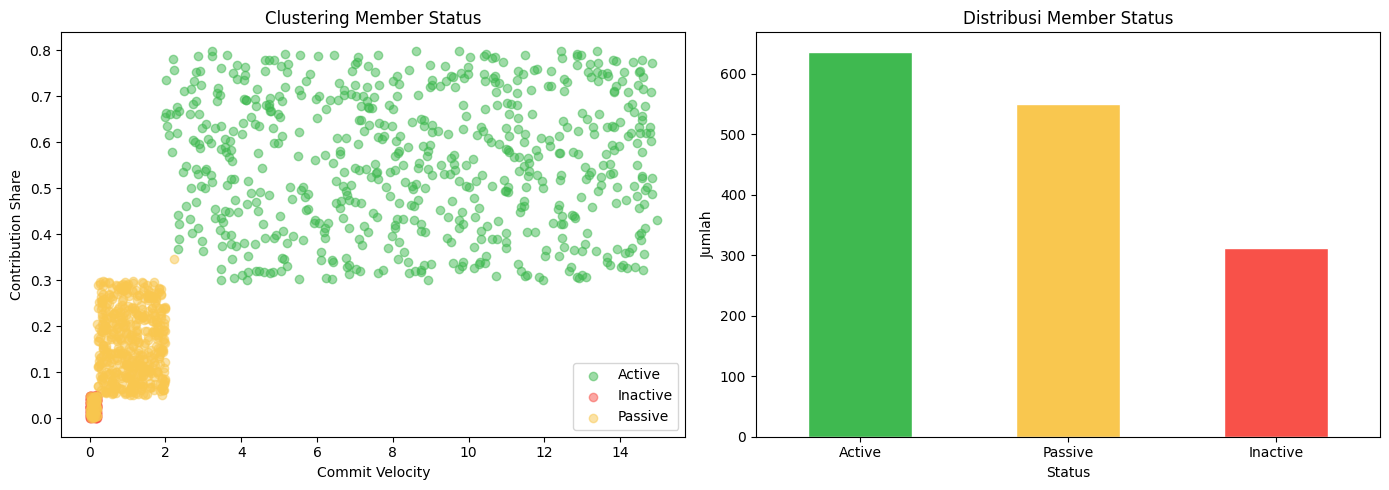

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors_map = {"Active": "#3FB950", "Passive": "#F9C74F", "Inactive": "#F85149"}
for status, group in df_member.groupby("member_status"):
    axes[0].scatter(group["commit_velocity"], group["contribution_share"],
                    label=status, alpha=0.5, color=colors_map[status])
axes[0].set_xlabel("Commit Velocity")
axes[0].set_ylabel("Contribution Share")
axes[0].set_title("Clustering Member Status")
axes[0].legend()

counts = df_member["member_status"].value_counts()
counts.plot(kind="bar",
            color=[colors_map[l] for l in counts.index],
            edgecolor="white", ax=axes[1])
axes[1].set_title("Distribusi Member Status")
axes[1].set_xlabel("Status")
axes[1].set_ylabel("Jumlah")
axes[1].tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.savefig("../data/model3_clusters.png", dpi=150)
plt.show()

In [ ]:
X = df_member[FEATURES]
y = df_member["member_status"]

sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X, y)
print(f"Sebelum SMOTE: {y.value_counts().to_dict()}")
print(f"Setelah SMOTE: {pd.Series(y_bal).value_counts().to_dict()}")

X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)

model_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

cv = cross_val_score(model_rf, X_bal, y_bal, cv=5, scoring="accuracy")
print(f"CV Accuracy: {cv.mean():.3f} ± {cv.std():.3f}")

Sebelum SMOTE: {'Active': 637, 'Passive': 551, 'Inactive': 312}
Setelah SMOTE: {'Active': 637, 'Passive': 637, 'Inactive': 637}

=== Classification Report ===
              precision    recall  f1-score   support

      Active       1.00      1.00      1.00       127
    Inactive       1.00      1.00      1.00       128
     Passive       1.00      1.00      1.00       128

    accuracy                           1.00       383
   macro avg       1.00      1.00      1.00       383
weighted avg       1.00      1.00      1.00       383

CV Accuracy: 0.999 ± 0.001


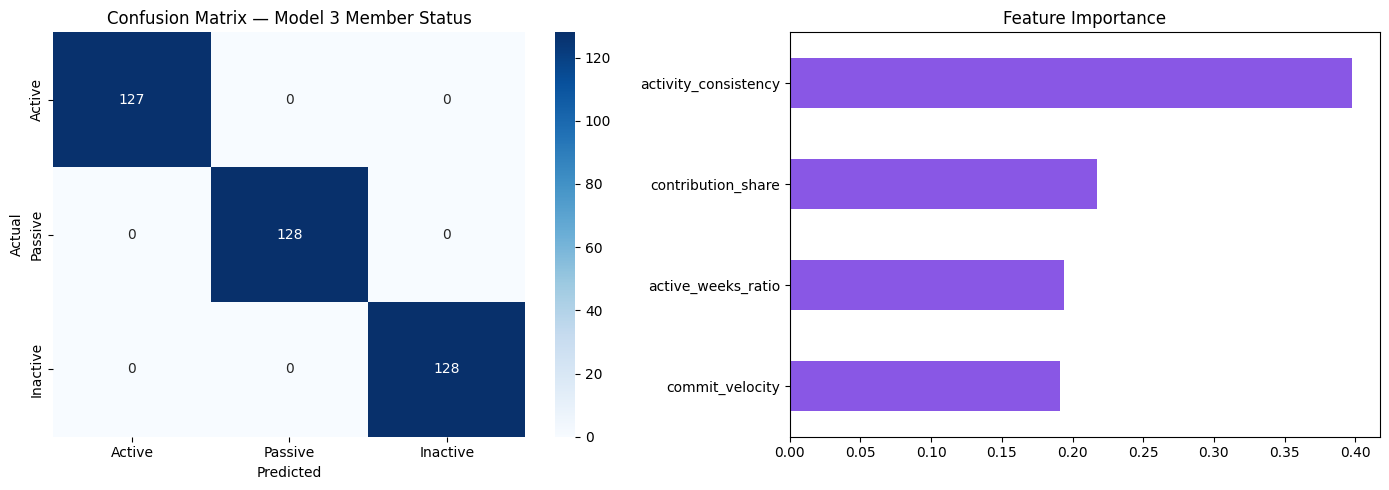

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(y_test, y_pred,
                      labels=["Active", "Passive", "Inactive"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Active", "Passive", "Inactive"],
            yticklabels=["Active", "Passive", "Inactive"], ax=axes[0])
axes[0].set_title("Confusion Matrix — Model 3 Member Status")
axes[0].set_ylabel("Actual")
axes[0].set_xlabel("Predicted")

importance = pd.Series(model_rf.feature_importances_,
                       index=FEATURES).sort_values()
importance.plot(kind="barh", color="#8957E5", ax=axes[1])
axes[1].set_title("Feature Importance")

plt.tight_layout()
plt.savefig("../data/model3_evaluation.png", dpi=150)
plt.show()

In [ ]:
joblib.dump(model_rf, "../models/model3_memberstatus.pkl")
joblib.dump(scaler,   "../models/model3_scaler.pkl")
print("✅ Model tersimpan!")

loaded = joblib.load("../models/model3_memberstatus.pkl")
test_cases = pd.DataFrame([
    # Active: commit sering, share besar, konsisten
    {"commit_velocity": 8.0,  "contribution_share": 0.6,
     "activity_consistency": 0.8, "active_weeks_ratio": 0.9},
    # Passive: commit jarang, share kecil
    {"commit_velocity": 0.8,  "contribution_share": 0.15,
     "activity_consistency": 2.5, "active_weeks_ratio": 0.4},
    # Inactive: hampir tidak ada commit
    {"commit_velocity": 0.05, "contribution_share": 0.01,
     "activity_consistency": 6.0, "active_weeks_ratio": 0.05},
])

preds = loaded.predict(test_cases)
print("\nTest prediksi:")
for i, pred in enumerate(preds):
    print(f"  Case {i+1}: {pred}")

✅ Model tersimpan!

Test prediksi:
  Case 1: Active
  Case 2: Passive
  Case 3: Inactive
